### The goal of this notebook is to identify which Bedmap1 points are covered by other datasets

In [1]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

import importlib
import numpy as np
import os
import pathlib
import shapefile as shp  # Requires the pyshp package; I ran `pip install pyshp`


In [9]:
import detangle_bedmap_utils
importlib.reload(detangle_bedmap_utils)
from detangle_bedmap_utils import (expand_range, find_closest_bedmap,
                                   load_bedmap_ll, load_bedmap_xy, 
                                   segment_indices, subsample_tracks_uniform, 
                                  )

In [3]:
gl_filepath = "/Users/lindzey/Data/Quantarctica3/Glaciology/ASAID/ASAID_GroundingLine_Simplified.shp"

# If I do it this way, I can plot as points (but not lines!). This is easier than having to iterate through each segment.
sf = shp.Reader(gl_filepath)
gl_xx = []
gl_yy = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    gl_xx.extend(x)
    gl_yy.extend(y)

In [4]:
bm1_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP1/BEDMAP1_1966-2000_AIR_BM1.csv"
bm1_lon, bm1_lat = load_bedmap_ll(bm1_path)
bm1_xx, bm1_yy = load_bedmap_xy(bm1_path)

## NIPR

In both BM1 & BM2:
* 1992_JARE33
* 1996_JARE37

In [5]:
duplicate_nipr_surveys = ["NIPR_1992_JARE33_GRN_BM3", "NIPR_1996_JARE37_GRN_BM3"]

In [6]:
nipr_xx = {}
nipr_yy = {}
nipr_bm1_idxs = {}

for idx, survey in enumerate(duplicate_nipr_surveys):
    survey_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP3/{}.csv".format(survey)
    nipr_xx[survey], nipr_yy[survey] = load_bedmap_xy(survey_path)
    nipr_bm1_idxs[survey] = find_closest_bedmap(nipr_xx[survey], nipr_yy[survey], bm1_xx, bm1_yy, subsampling=200)    

Subsampled 1082 -> 1076
Subsampled 6480 -> 6323


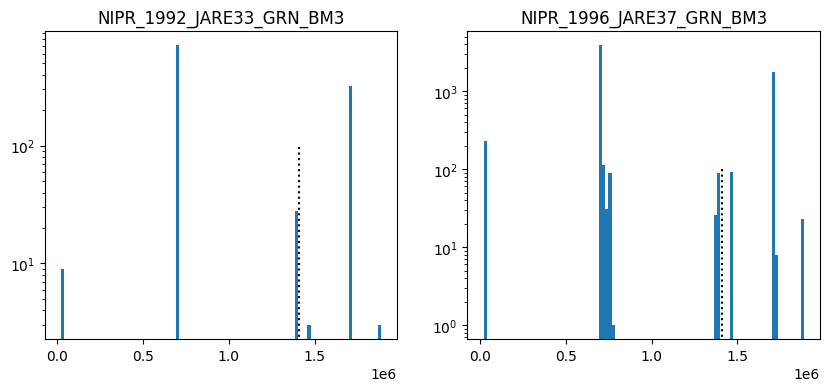

In [7]:
fig = plt.figure(figsize=(10,4))
axs = fig.subplots(1,2)

for idx, survey in enumerate(duplicate_nipr_surveys):
    ax = axs[idx]
    ax.hist(nipr_bm1_idxs[survey], bins=100);
    ax.set_title(survey)
    ax.set_yscale('log')
    
    ax.vlines([1.41e6], 0, 100, linestyle='dotted', colors='black')


The NIPR JARE surveys don't appear to have been added to BEDMAP1 in order -- there are multiple chunks per survey, and even where there are contiguous bedmap sections for NIPR, the surveys are interleaved.

This made using ths histogram approach a dead end.

Instead, go more brute-force, plotting all possible segments and manually selecting the ones that align, discarding those that belong to an intersecting line.

In [22]:
jare33_survey = "NIPR_1992_JARE33_GRN_BM3"
jare37_survey = "NIPR_1996_JARE37_GRN_BM3"

jare33_idxs = list(set(nipr_bm1_idxs["NIPR_1992_JARE33_GRN_BM3"]))
jare33_idxs.sort()
jare37_idxs = list(set(nipr_bm1_idxs["NIPR_1996_JARE37_GRN_BM3"]))
jare37_idxs.sort()

In [19]:
jare33_segments = segment_indices(jare33_idxs, 1, 5)
print(len(jare33_segments))
jare37_segments = segment_indices(jare37_idxs, 1, 5)
print(len(jare37_segments))

6
72


for idx 0, row = 0, col = 0
for idx 1, row = 0, col = 1
for idx 2, row = 0, col = 2
for idx 3, row = 1, col = 0
for idx 4, row = 1, col = 1
for idx 5, row = 1, col = 2


/var/folders/1g/6wtmt7_d2l77dqx8zgth07580000gn/T/ipykernel_35995/2422921055.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nrows = np.int(np.ceil(len(jare33_segments) / ncols))


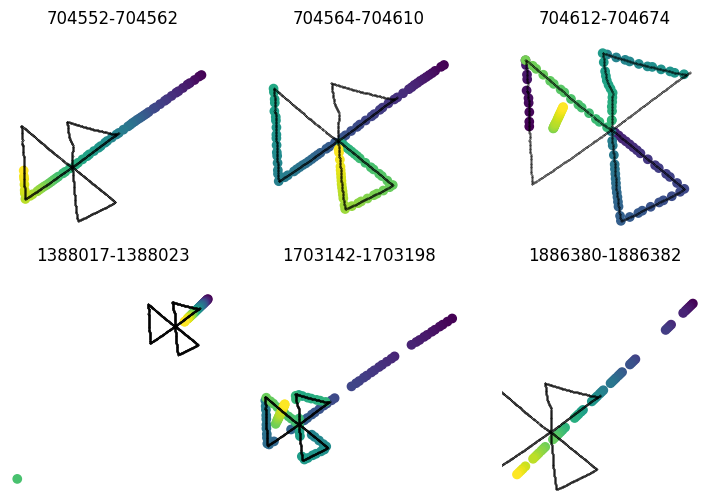

In [20]:
# Plot segments with a buffer around them in order to see if they're part of a line that crossed this survey

ncols = 3
nrows = np.int(np.ceil(len(jare33_segments) / ncols))

fig = plt.figure(figsize=(3*ncols, 3*nrows))
axes = fig.subplots(nrows, ncols)

extend = 25  # How many *points* to extend the segment in order to 
for ax_idx, (s0, s1) in enumerate(jare33_segments):
    min_idx = max(0, s0-extend)
    max_idx = min(s1+extend, len(bm1_xx))
    idxs = np.arange(min_idx, max_idx)
    row = int(np.floor(ax_idx / ncols))
    col = ax_idx % ncols
    ax = axes[row][col]
    ax.axis('equal')
    ax.axis('off')
    xx = bm1_xx[idxs]
    yy = bm1_yy[idxs]
    ax.scatter(xx, yy, c=idxs, edgecolors=None)
    ax.plot(nipr_xx[survey], nipr_yy[survey], 'k.', markersize=0.5)
    ax.set_title("{}-{}".format(s0, s1))
    border = 10000 
    ax.set_xlim((np.min(xx)-border, np.max(xx)+border))
    ax.set_ylim((np.min(yy)-border, np.max(yy)+border))
    


In [23]:
# See about extending the bedmap range a bit, in case we missed any
radius = 10000
group1_start, group1_end = expand_range(np.arange(704_564, 704_611), nipr_xx[jare33_survey], nipr_yy[jare33_survey], bm1_xx, bm1_yy, radius)
group2_start, group2_end = expand_range(np.arange(1_703_142, 1_703_198), nipr_xx[jare33_survey], nipr_yy[jare33_survey], bm1_xx, bm1_yy, radius)


For BM1 idx 704549, min_dist = 10.21 km
For BM1 idx 704676, min_dist = 10.31 km
For BM1 idx 1703139, min_dist = 28.67 km
For BM1 idx 1703199, min_dist = 10.17 km


/var/folders/1g/6wtmt7_d2l77dqx8zgth07580000gn/T/ipykernel_35995/3812844112.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nrows = np.int(np.ceil(len(jare37_segments) / ncols))


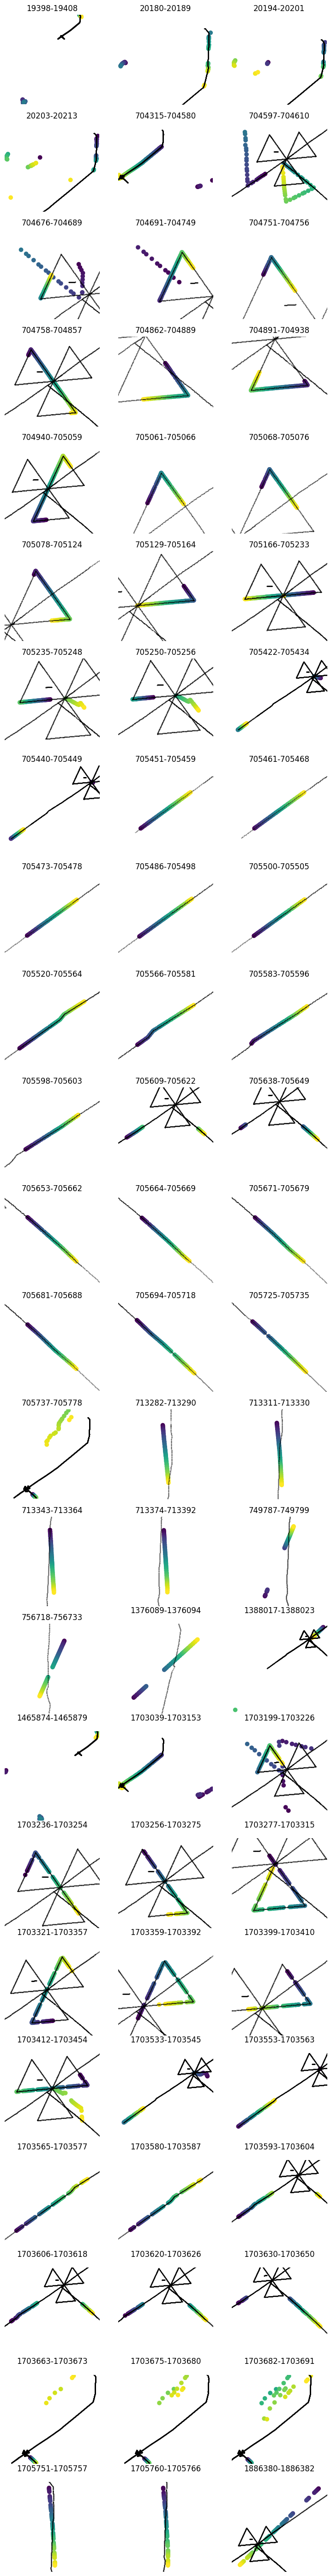

In [24]:
# Plot segments with a buffer around them in order to see if they're part of a line that crossed this survey
ncols = 3
nrows = np.int(np.ceil(len(jare37_segments) / ncols))

fig = plt.figure(figsize=(3*ncols, 3*nrows))
axes = fig.subplots(nrows, ncols)


extend = 25
for ax_idx, (s0, s1) in enumerate(jare37_segments):
    min_idx = max(0, s0-extend)
    max_idx = min(s1+extend, len(bm1_xx))
    idxs = np.arange(min_idx, max_idx)
    row = int(np.floor(ax_idx / ncols))
    col = ax_idx % ncols
    ax = axes[row][col]
    ax.axis('equal')
    ax.axis('off')
    xx = bm1_xx[idxs]
    yy = bm1_yy[idxs]
    ax.scatter(xx, yy, c=idxs, edgecolors=None)
    ax.plot(nipr_xx[jare37_survey], nipr_yy[jare37_survey], 'k.', markersize=0.5)
    ax.set_title("{}-{}".format(s0, s1))
    border = 10000 
    ax.set_xlim((np.min(xx)-border, np.max(xx)+border))
    ax.set_ylim((np.min(yy)-border, np.max(yy)+border))
    


Text(0.5, 1.0, 'NIPR_1992_JARE33_GRN_BM3')

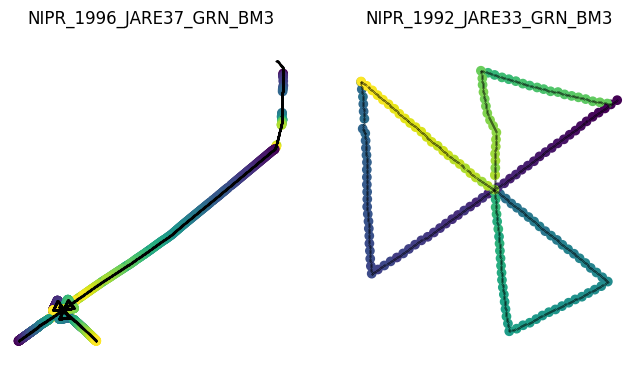

In [25]:
# Plot the selected segments to confirm
jare37_segments = [
    # The easting-most north-south part of the survey; very patchy                
    (20180, 20213),
    # Easting part of the SW-NE line
    # I kind of think this should've been JARE33 instead, because right after it goes into that triangle.
    # However, in the bedmap dataset, only JARE37 has this line.
    (704315, 704580),
    # six cross lines (three triangles)
    (704676, 705258),
    # Westing part of the SW-NE line
    (705421, 705637),
    # Southing part of the NW-SE line
    (705638, 705782),

    # Repeat of the NW-NE line
    (1_703_037, 1_703_141),
    # Repeat of the six crossing lines
    (1_703_199, 1_703_455),
    # Repeat of the shorter legs
    (1_703_529, 1_703_691), 

]                    

jare33_segments = [
    (704_552, 704_675),
    (1_703_142, 1_703_198),
    #(705_259, 705_420), # This is the unattributed survey nearby.
]                    


fig = plt.figure(figsize=(8,4))
ax1, ax2 = fig.subplots(1,2)
for ax in [ax1, ax2]:
    ax.axis('equal')
    ax.axis('off')

ax1.plot(nipr_xx[jare37_survey], nipr_yy[jare37_survey], 'k.', markersize=0.5)
for s0, s1 in jare37_segments:
    idxs = np.arange(s0, s1+1)
    ax1.scatter(bm1_xx[idxs], bm1_yy[idxs], c=idxs, edgecolors=None)
ax1.set_title(jare37_survey)

ax2.plot(nipr_xx[jare33_survey], nipr_yy[jare33_survey], 'k.', markersize=0.5)
for s0, s1 in jare33_segments:
    idxs = np.arange(s0, s1+1)
    ax2.scatter(bm1_xx[idxs], bm1_yy[idxs], c=idxs, edgecolors=None)
ax2.set_title(jare33_survey)
    


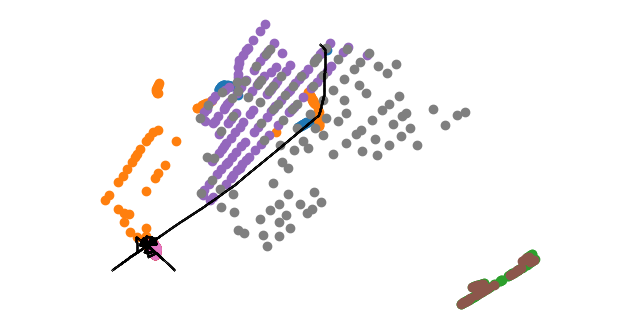

In [26]:
# And, plot what's happening around those segments, to check we haven't missed any.
mystery_segments = [
    # The easting-most north-south part of the survey; very patchy   
    # Nothing around it seems to be related.
    (20_100, 20_179),
    #     (20180, 20213),  # JARE37
    (20_214, 20_300),
    
    # Easting part of the SW-NE line
    (704_200, 704_314),
    #(704315, 704580), # JARE37
    #(704_552, 704_675), # JARE33
    # six cross lines (three triangles)
    #(704676, 705258), # JARE37
    (705_259, 705_420),   ### QUESTION: This is the unattributed survey nearby that I suspect may be NIPR?
    # Westing part of the SW-NE line
    #(705421, 705637), # JARE37
    # Southing part of the NW-SE line
    #(705638, 705782), # JARE 37
    (705_783, 705_900),
    # Repeat of the six crossing lines
    (1_703_000, 1_703_036),
    #(1_703_037, 1_703_141), # TODO: This should be part of a survey! Call it part of JARE37?
    # (1_703_142, 1_703_198), # JARE33
    # (1_703_199, 1_703_455), # JARE37
    (1_703_456, 1_703_528),  ### QUESTION: That mystery survey again
    #(1_703_529, 1_703_691), # TODO: JARE37 again, shorter legs
    (1_703_692, 1_703_800),
]     
fig = plt.figure(figsize=(8,4))
ax = fig.subplots(1,1)
ax.axis('equal')
ax.axis('off')

ax.plot(nipr_xx[jare37_survey], nipr_yy[jare37_survey], 'k.', markersize=0.2)
ax.plot(nipr_xx[jare33_survey], nipr_yy[jare33_survey], 'k.', markersize=0.2)

for s0, s1 in mystery_segments:
    idxs = np.arange(s0, s1+1)
    ax.scatter(bm1_xx[idxs], bm1_yy[idxs], edgecolors=None)
    

882466.3568727135 911300.7906431142


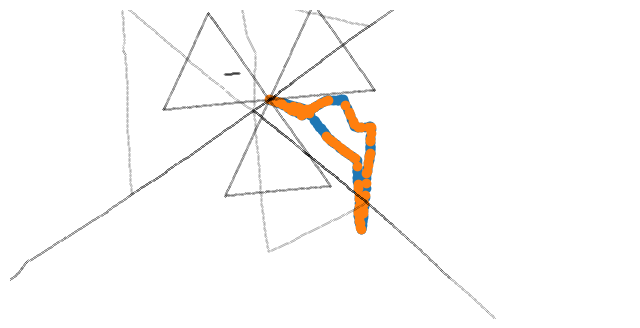

In [27]:
# Finally, create a plot of the two segments that we think are NIPR
mystery_segments = [
    (705_259, 705_420),   ### QUESTION: This is the unattributed survey nearby that I suspect may be NIPR?
    (1_703_456, 1_703_528),  ### QUESTION: That mystery survey again
]     
fig = plt.figure(figsize=(8,4))
ax = fig.subplots(1,1)
ax.axis('equal')
ax.axis('off')

ax.plot(nipr_xx[jare37_survey], nipr_yy[jare37_survey], 'k.', markersize=0.2)
ax.plot(nipr_xx[jare33_survey], nipr_yy[jare33_survey], 'k.', markersize=0.2)

minx = np.inf
maxx = -np.inf
miny = np.inf
maxy = -np.inf

for s0, s1 in mystery_segments:
    idxs = np.arange(s0, s1+1)
    xx = bm1_xx[idxs]
    yy = bm1_yy[idxs]
    minx = min(np.min(xx), minx)
    miny = min(np.min(yy), miny)
    maxx = max(np.max(xx), maxx)
    maxy = max(np.max(yy), maxy)

    ax.scatter(bm1_xx[idxs], bm1_yy[idxs], edgecolors=None)
    
margin = 25000
print(minx, maxx)
ax.set_xlim(minx-margin, maxx+margin)
ax.set_ylim([miny-margin, maxy+margin])
fig.savefig("mystery_nipr_survey.png")